# Exploratory Data Analysis of CESM2-WACCM SSP2-4.5 Data

This notebook demonstrates how to use `intake-esm` to access and analyze climate model output from the CESM2-WACCM SSP2-4.5 experiment. We will focus on the near-surface air temperature variables: `TREFHT` (average), `TREFHTMN` (minimum), and `TREFHTMX` (maximum).

In [1]:
!pip install -q intake intake-esm xarray[complete] matplotlib s3fs zarr fsspec[s3] cartopy

In [ ]:
import os
os.kill(os.getpid(), 9)

In [2]:
import intake
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import requests
import json
import pandas as pd

## 1. Load the Data Catalog

In [3]:
# --- Cell 2: Load the Data Catalog ---
# URLs for the catalog JSON and its corresponding CSV data file
catalog_url = 'https://raw.githubusercontent.com/NCAR/CESM2-ARISE/main/catalogs/cesm2-waccm-ssp245.json'
csv_url = 'https://raw.githubusercontent.com/NCAR/CESM2-ARISE/main/catalogs/cesm2-waccm-ssp245'

# Fetch the catalog specification from the JSON file
response = requests.get(catalog_url)
catalog_spec = response.json()

# Fetch the data assets from the CSV file into a pandas DataFrame
df = pd.read_csv(csv_url)

# The catalog has a null 'id' which causes a validation error. We'll manually set it.
if catalog_spec.get('id') is None:
    catalog_spec['id'] = 'cesm2-waccm-ssp245-catalog'

# Construct the dictionary that intake-esm expects, combining the spec and the dataframe.
# This bypasses the parsing errors with the older catalog format.
esm_datastore_dict = {
    'esmcat': catalog_spec,
    'df': df
}

# Open the ESM datastore from the constructed dictionary
col = intake.open_esm_datastore(esm_datastore_dict)


# Display the first few entries of the catalog
col.df

,path,variable,experiment,member_id,long_name,units,vertical_levels,frequency
0,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,ABSORB,5-WACCM,001,"Aerosol absorption, day only",/m,1.0,month_1
1,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,ABSORB,5-WACCM,001,"Aerosol absorption, day only",/m,1.0,month_1
2,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,ACBZO2,5-WACCM,001,ACBZO2 concentration,mol/mol,1.0,month_1
3,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,ACBZO2,5-WACCM,001,ACBZO2 concentration,mol/mol,1.0,month_1
4,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,ACTREL,5-WACCM,001,Average Cloud Top droplet effective radius,Micron,1.0,month_1
...,...,...,...,...,...,...,...,...
58518,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,zoo_loss_zint_100m,5-WACCM,010,"Zooplankton Loss Vertical Integral, 0-100m",mmol/m^3 cm/s,1.0,month_1
58519,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,zsatarag,5-WACCM,010,Aragonite Saturation Depth,cm,1.0,month_1
58520,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,zsatarag,5-WACCM,010,Aragonite Saturation Depth,cm,1.0,month_1
58521,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,zsatcalc,5-WACCM,010,Calcite Saturation Depth,cm,1.0,month_1


## 2. Search for Variables of Interest

In [5]:
# Define the variables and experiment we are interested in
# variables = ['TREFHT', 'TREFHTMN', 'TREFHTMX']
variables = ['TREFHT']
experiment = '5-WACCM'

# Search the catalog
cat = col.search(experiment=experiment, variable=variables, frequency='day_1', member_id='001')

# Display the search results
cat.df

,path,variable,experiment,member_id,long_name,units,vertical_levels,frequency
0,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,TREFHT,5-WACCM,001,Reference height temperature,K,1.0,day_1
1,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,TREFHT,5-WACCM,001,Reference height temperature,K,1.0,day_1
2,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,TREFHT,5-WACCM,001,Reference height temperature,K,1.0,day_1
3,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,TREFHT,5-WACCM,001,Reference height temperature,K,1.0,day_1
4,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,TREFHT,5-WACCM,001,Reference height temperature,K,1.0,day_1
5,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,TREFHT,5-WACCM,001,Reference height temperature,K,1.0,day_1
6,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,TREFHT,5-WACCM,001,Reference height temperature,K,1.0,day_1
7,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,TREFHT,5-WACCM,001,Reference height temperature,K,1.0,day_1
8,s3://ncar-cesm2-arise/CESM2-WACCM-SSP245/metad...,TREFHT,5-WACCM,001,Reference height temperature,K,1.0,day_1


## 3. Load Data into an Xarray Dataset

In [7]:
import xarray as xr
import s3fs
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up download directory
download_dir = Path('cesm_data')
download_dir.mkdir(exist_ok=True)

print(f"📁 Download directory: {download_dir.absolute()}")

# Get the metadata paths and extract NetCDF file paths
df = cat.df
metadata_paths = df['path'].tolist()

fs = s3fs.S3FileSystem(anon=True)
netcdf_files = []

print("🔍 Extracting NetCDF file paths from metadata...")
for metadata_path in metadata_paths:
    try:
        with fs.open(metadata_path, 'r') as f:
            metadata = json.load(f)
        if 'templates' in metadata and 'u' in metadata['templates']:
            netcdf_files.append(metadata['templates']['u'])
    except Exception as e:
        print(f"Error reading {metadata_path}: {e}")

print(f"📊 Found {len(netcdf_files)} NetCDF files to download")

# Download files
def download_netcdf_files(netcdf_files, download_dir, max_files=None):
    """Download NetCDF files from S3 to local directory"""
    downloaded_files = []

    # Limit files if specified (useful for testing)
    if max_files:
        netcdf_files = netcdf_files[:max_files]

    for i, s3_path in enumerate(netcdf_files):
        try:
            # Extract filename from S3 path
            filename = s3_path.split('/')[-1]
            local_path = download_dir / filename

            # Skip if already downloaded
            if local_path.exists():
                print(f"✅ File {i+1}/{len(netcdf_files)}: {filename} (already exists)")
                downloaded_files.append(local_path)
                continue

            print(f"⬇️  Downloading {i+1}/{len(netcdf_files)}: {filename}")

            # Download file
            with fs.open(s3_path, 'rb') as remote_file:
                with open(local_path, 'wb') as local_file:
                    local_file.write(remote_file.read())

            downloaded_files.append(local_path)
            print(f"✅ Downloaded: {filename} ({local_path.stat().st_size / 1024**2:.1f} MB)")

        except Exception as e:
            print(f"❌ Failed to download {s3_path}: {str(e)[:100]}")

    return downloaded_files

# Download files (start with first 2 for testing)
print("\n🚀 Starting download...")
print("Starting with first 2 files for testing. Change max_files=None to download all.")
downloaded_files = download_netcdf_files(netcdf_files, download_dir, max_files=None)

if not downloaded_files:
    print("❌ No files downloaded successfully!")
    exit()

print(f"\n✅ Successfully downloaded {len(downloaded_files)} files")

📁 Download directory: /workspaces/climate-research-workbench/notebooks/tool/cesm_data
🔍 Extracting NetCDF file paths from metadata...
📊 Found 9 NetCDF files to download

🚀 Starting download...
Starting with first 2 files for testing. Change max_files=None to download all.
⬇️  Downloading 1/9: b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20150101-20241231.nc
✅ Downloaded: b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20150101-20241231.nc (440.8 MB)
⬇️  Downloading 2/9: b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20250101-20341231.nc
✅ Downloaded: b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20250101-20341231.nc (440.5 MB)
⬇️  Downloading 3/9: b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20350101-20441231.nc
✅ Downloaded: b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20350101-20441231.nc (440.3 MB)
⬇️  Downloading 4/9: b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4

In [8]:
import xarray as xr
from pathlib import Path
import os

# Input and output folders
ori_folder = Path("cesm_data")
sliced_folder = Path("sliced")
sliced_folder.mkdir(exist_ok=True)

# Loop over all files in original folder
for file_name in os.listdir(ori_folder):
    file_path = ori_folder / file_name
    if file_path.is_file():
        try:
            # Load dataset
            ds = xr.open_dataset(file_path, engine='netcdf4')

            # Slice lat/lon
            ds_sel = ds.sel(lat=slice(-15, 30), lon=slice(90, 140))

            # Define output path
            output_file = sliced_folder / f"SEA_{file_name}"

            # Save sliced dataset
            ds_sel.to_netcdf(output_file)
            print(f"✅ Saved: {output_file}")

            # Close dataset
            ds.close()
            ds_sel.close()
        except Exception as e:
            print(f"❌ Failed to process {file_path}: {e}")


✅ Saved: sliced/SEA_b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20550101-20641231.nc
✅ Saved: sliced/SEA_b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20350101-20441231.nc
✅ Saved: sliced/SEA_b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20150101-20241231.nc
✅ Saved: sliced/SEA_b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20750101-20841231.nc
✅ Saved: sliced/SEA_b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20650101-20741231.nc
✅ Saved: sliced/SEA_b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20950101-21001231.nc
✅ Saved: sliced/SEA_b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20250101-20341231.nc
✅ Saved: sliced/SEA_b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20450101-20541231.nc
✅ Saved: sliced/SEA_b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.cam.h1.TREFHT.20850101-20941231.nc


In [19]:
!du -h cesm_data

882M	cesm_data


In [20]:
!du -h sliced


35M	sliced


In [10]:
import xarray as xr
from pathlib import Path
import pandas as pd
import os

ori_folder = Path("sliced")
output_csv = "sliced_metadata.csv"
data = []

for file in sorted(os.listdir(ori_folder)):
    file_path = ori_folder / file

    if not file.endswith(".nc"):
        continue

    try:
        parts = file.split(".")
        variable = parts[-3]  # e.g., TREFHT
        frequency_code = parts[-4]  # e.g., h1
        experiment = parts[4]  # CMIP6-SSP2-4.5-WACCM
        member_id = parts[5]  # 001

        # Frequency mapping
        freq_map = {"h0": "mon_1", "h1": "day_1", "h2": "6hr", "h3": "hr"}
        frequency = freq_map.get(frequency_code, "unknown")

        # Load dataset
        ds = xr.open_dataset(file_path, engine='netcdf4')
        da = ds[variable]

        long_name = da.attrs.get("long_name", "")
        units = da.attrs.get("units", "")
        vertical_levels = float(da.shape[1]) if len(da.shape) > 2 else 1.0

        data.append({
            "path": f"s3://your-bucket-name/{file_path}",
            "variable": variable,
            "experiment": experiment,
            "member_id": member_id,
            "long_name": long_name,
            "units": units,
            "vertical_levels": 1.0,
            "frequency": frequency
        })
    except Exception as e:
        print(f"Skipping file with unexpected structure: {file} — {e}")

# Save as CSV with tab separator
df = pd.DataFrame(data)
df.to_csv(output_csv, sep=",", index=False)
print(f"✅ Saved {output_csv} with {len(df)} entries")


✅ Saved sliced_metadata.csv with 9 entries


In [22]:
df = pd.read_csv("sliced_metadata.csv")
df.head()

,path,variable,experiment,member_id,long_name,units,vertical_levels,frequency
0,s3://your-bucket-name/sliced/SEA_b.e21.BWSSP24...,TREFHT,CMIP6-SSP2-4,5-WACCM,Reference height temperature,K,48.0,day_1
1,s3://your-bucket-name/sliced/SEA_b.e21.BWSSP24...,TREFHTMX,CMIP6-SSP2-4,5-WACCM,Maximum reference height temperature over outp...,K,48.0,day_1


## 4. Exploratory Data Analysis (EDA)

<xarray.Dataset> Size: 58MB
Dimensions:       (lat: 48, lon: 41, lev: 70, ilev: 71, time: 3650, nbnd: 2)
Coordinates:
  * lat           (lat) float64 384B -14.61 -13.66 -12.72 ... 27.8 28.74 29.69
  * lon           (lon) float64 328B 90.0 91.25 92.5 93.75 ... 137.5 138.8 140.0
  * lev           (lev) float64 560B 5.96e-06 9.827e-06 1.62e-05 ... 976.3 992.6
  * ilev          (ilev) float64 568B 4.5e-06 7.42e-06 1.223e-05 ... 985.1 1e+03
  * time          (time) object 29kB 2015-01-01 00:00:00 ... 2024-12-31 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/27)
    gw            (lat) float64 384B dask.array<chunksize=(48,), meta=np.ndarray>
    hyam          (lev) float64 560B dask.array<chunksize=(70,), meta=np.ndarray>
    hybm          (lev) float64 560B dask.array<chunksize=(70,), meta=np.ndarray>
    P0            float64 8B 1e+05
    hyai          (ilev) float64 568B dask.array<chunksize=(71,), meta=np.ndarray>
    hybi          (ilev) float64 568B dask.array<chunk

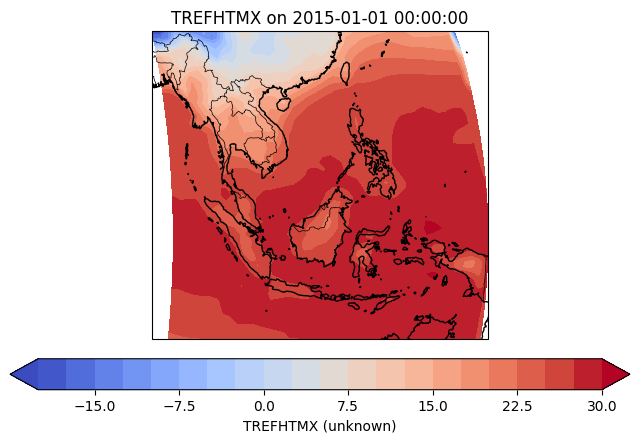

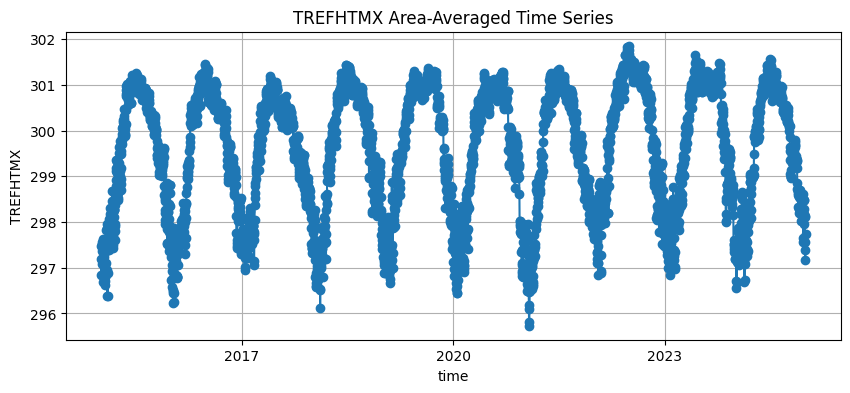

In [25]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# Step 1: Load all sliced NetCDF files
sliced_files = sorted(Path("sliced").glob("*.nc"))
ds = xr.open_mfdataset([str(f) for f in sliced_files], combine='by_coords', engine='netcdf4')

# Step 2: Select a variable
var = "TREFHTMX"

# Step 3: Print dataset info
print(ds)
print(f"\nVariable: {var}")
print(ds[var])
print("Attributes:", ds[var].attrs)

# Step 4: Coordinate check
print("\nCoordinate ranges:")
print("  Lat:", float(ds.lat.min()), "to", float(ds.lat.max()))
print("  Lon:", float(ds.lon.min()), "to", float(ds.lon.max()))
print("  Time:", str(ds.time.values[0]), "to", str(ds.time.values[-1]))

# Step 5: Basic statistics
print("\nStatistics:")
print("  Min:", float(ds[var].min()))
print("  Max:", float(ds[var].max()))
print("  Mean:", float(ds[var].mean()))
print("  Std Dev:", float(ds[var].std()))

# Step 6: Plot with Cartopy (Robinson projection)
# Convert to Celsius if in Kelvin
field = ds[var].isel(time=0)
if field.attrs.get("units", "").lower().startswith("k"):
    field = field - 273.15

data_cyclic, lons_cyclic = add_cyclic_point(field.values, coord=field["lon"].values)

fig, ax = plt.subplots(
    figsize=(10, 5),
    subplot_kw={"projection": ccrs.Robinson()}
)

cs = ax.contourf(
    lons_cyclic,
    field["lat"],
    data_cyclic,
    levels=21,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    extend="both"
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_title(f"{var} on {str(ds.time.values[0])}")

cbar = plt.colorbar(cs, orientation="horizontal", pad=0.05, shrink=0.8)
cbar.set_label(f"{var} ({field.attrs.get('units', 'unknown')})")

plt.show()

# Step 7: Time Series (Area-Averaged)
ds[var].mean(dim=["lat", "lon"]).plot(figsize=(10, 4), marker='o')
plt.title(f"{var} Area-Averaged Time Series")
plt.ylabel(var)
plt.grid(True)
plt.show()
